## Zmiany danych źrodłowych o sprzedaży

In [1]:
import numpy as np
import pandas as pd
import requests

In [2]:
sales_df = pd.read_csv('sales_data_sample.csv', encoding='cp1250')

### Uwspółcześnienie dat
Zmiana na daty współczesne (z lat 2003-2005 na 2020-2022).

In [3]:
sales_df['ORDERDATE'] = sales_df['ORDERDATE'].astype("datetime64")

In [4]:
# zakres dat w oryginalnych danych
sales_df['ORDERDATE'].min(), sales_df['ORDERDATE'].max()

(Timestamp('2003-01-06 00:00:00'), Timestamp('2005-05-31 00:00:00'))

In [5]:
# dni tygodnia w oryginalnych danych
# 0 - poniedziałek, 6 - niedziela
# są zarejestrowane sprzedaze we wszystkie, więc mozna po prostu przesunac date 
# bez zwracania uwagi na dni tygodnia
sales_df["ORDERDATE"].dt.dayofweek.value_counts()

4    598
2    562
3    538
1    515
0    366
5    123
6    121
Name: ORDERDATE, dtype: int64

In [6]:
sales_df["ORDERDATE"] = sales_df["ORDERDATE"] + pd.offsets.DateOffset(years=17)

In [7]:
# zakres dat w zmienionych danych
sales_df['ORDERDATE'].min(), sales_df['ORDERDATE'].max()

(Timestamp('2020-01-06 00:00:00'), Timestamp('2022-05-31 00:00:00'))

In [8]:
# dni tygodnia w zmienionych danych
# dalej najmniej pozostaje w niedziele - OK
sales_df["ORDERDATE"].dt.dayofweek.value_counts()

2    567
4    567
3    535
1    429
5    321
0    305
6     99
Name: ORDERDATE, dtype: int64

In [9]:
sales_df.YEAR_ID = sales_df.ORDERDATE.dt.year
sales_df.QTR_ID = sales_df.ORDERDATE.dt.quarter
sales_df.MONTH_ID = sales_df.ORDERDATE.dt.month

### Zmiany walutowe

#### Zmiana SuggestedRetailPrice na cenę wyrażoną w złotówkach
(oryginalnie prawdopodobnie cena jest w dolarach amerykańskich)

In [10]:
# żeby zachować sugerowaną cenę w intach 
sales_df.MSRP =  sales_df.MSRP * 4 

#### Naprawa przycietej ceny 

<AxesSubplot:>

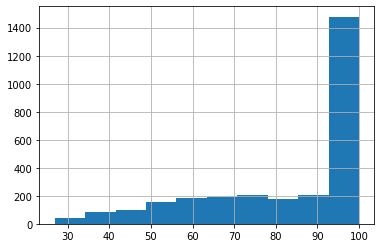

In [11]:
# cena sprzedazy jest przycieta do wartosci 100
sales_df.PRICEEACH.hist()

In [12]:
# przez to nie zgadza sie wyliczenie lacznej kwoty sprzedazy dla 1304 rekordow 
mask = np.abs(sales_df["PRICEEACH"] * sales_df["QUANTITYORDERED"] - sales_df["SALES"]) > 0.01
tmp = sales_df[mask]
tmp.PRICEEACH.value_counts()

100.0    1304
Name: PRICEEACH, dtype: int64

In [13]:
# naprawa
sales_df.loc[mask, "PRICEEACH"] = sales_df.loc[mask, "SALES"] / sales_df.loc[mask, "QUANTITYORDERED"]

In [14]:
# sprawdzenie
np.mean(np.abs(sales_df["PRICEEACH"] * sales_df["QUANTITYORDERED"] - sales_df["SALES"]) < 0.0001)

1.0

#### Zmiana walut na waluty poszczególnych krajów

In [15]:
sales_df["PRICEEACH"] = sales_df["PRICEEACH"] * 4

In [16]:
country_currency_dict = {
    'Australia': "AUD",
    'Austria': "EUR",
    'Belgium': "EUR",
    'Canada': "CAD", 
    'Denmark': "EUR", 
    'Finland': "EUR",
    'France': "EUR", 
    'Germany': "EUR", 
    'Ireland': "EUR", 
    'Italy': "EUR", 
    'Japan': "JPY", 
    'Norway': "NOK",
    'Philippines': "PHP",
    'Singapore': "SGD", 
    'Spain': "EUR", 
    'Sweden': "SEK", 
    'Switzerland': "CHF", 
    'UK': "GBP",
    'USA': "USD"
}

In [17]:
sales_df['CURRENCY'] = sales_df['COUNTRY'].map(country_currency_dict)

In [18]:
API_URL = "http://api.nbp.pl/api/exchangerates/rates/{table}/{code}/{date}/?format=json"
currency_rates = {}
unique_currencies = sales_df['CURRENCY'].unique()
for currency in unique_currencies:
    r = requests.get(API_URL.format(table='a', code=currency, date='2022-05-20'))
    currency_rates[currency] = r.json()["rates"][0]["mid"]

In [19]:
def change_price_to_local_currency(row):
    return np.round(row.PRICEEACH/currency_rates[row.CURRENCY], 2)

In [20]:
sales_df["PRICEEACH"] = sales_df.apply(change_price_to_local_currency, axis=1)

In [21]:
sales_df["SALES"] = sales_df["PRICEEACH"] * sales_df["QUANTITYORDERED"]

In [22]:
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,CURRENCY
0,10107,30,87.33,2,2619.90,2020-02-24,Shipped,1,2,2020,...,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small,USD
1,10121,34,70.18,5,2386.12,2020-05-07,Shipped,2,5,2020,...,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small,EUR
2,10134,41,81.73,2,3350.93,2020-07-01,Shipped,3,7,2020,...,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium,EUR
3,10145,45,75.98,6,3419.10,2020-08-25,Shipped,3,8,2020,...,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium,USD
4,10159,49,96.94,14,4750.06,2020-10-10,Shipped,4,10,2020,...,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,96.81,15,1936.20,2021-12-02,Shipped,4,12,2021,...,NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small,EUR
2819,10373,29,118.35,1,3432.15,2022-01-31,Shipped,1,1,2022,...,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium,EUR
2820,10386,43,108.69,4,4673.67,2022-03-01,Resolved,1,3,2022,...,NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium,EUR
2821,10397,34,53.69,1,1825.46,2022-03-28,Shipped,1,3,2022,...,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small,EUR


## Zapisanie i podział na dwie ramki

In [41]:
sales_df.to_csv("sales_data.csv", index=False, sep=';')

In [36]:
sales_historic = sales_df[sales_df["ORDERDATE"] < '2022-04-01']
sales_new = sales_df[sales_df["ORDERDATE"] >= '2022-04-01']

In [39]:
sales_historic.to_csv("sales_historic.csv", index=False, sep=';')

In [40]:
sales_new.to_csv("sales_new.csv", index=False, sep=';')